In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pprint import pprint
import spacy
from spacy.tokenizer import _get_regex_pattern
import nltk
from nltk.corpus import stopwords
import re
from spacy.matcher import Matcher
import spacy
from spacymoji import Emoji
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.feature_extraction.text import CountVectorizer

## Tinder Swindler 100k Tweets

In [9]:
# load the dataset
file = './TinderSwindlerVersion2.csv'
df = pd.read_csv(file)

In [10]:
df.head(10)

,user_name,user_location,user_created,user_followers,user_verified,date,text,source,is_retweet
0,globalnode.saito 🟥🐳🐈‍⬛,Travelling the World on Web3,2009-06-03 20:18:22+00:00,768,False,2022-02-09 17:09:22+00:00,"@T1gmee Tinder Swindler, off Netflix",Twitter for iPhone,False
1,Ungovernable 🇧🇮,NaN,2011-09-04 22:46:26+00:00,385,False,2022-02-09 17:09:18+00:00,"#tinderswindler , basically homeboy got away w...",Twitter for iPhone,False
2,Adefolake,NaN,2009-06-02 14:18:44+00:00,1994,False,2022-02-09 17:09:17+00:00,Not the tinder swindler becoming a TIk Tok sta...,Twitter for iPhone,False
3,✧ ☽,Noord-Brabant,2012-02-12 07:35:26+00:00,336,False,2022-02-09 17:09:07+00:00,Why isn’t Shimon Hayut in jail ????? #thetinde...,Twitter for iPhone,False
4,chivo. 🥶,PG/MD,2010-03-22 21:23:17+00:00,1046,False,2022-02-09 17:09:06+00:00,the tinder swindler a sick nigga 😂😂,Twitter Web App,False
5,kira,"Toronto, Ontario",2010-07-02 12:50:53+00:00,362,False,2022-02-09 17:09:03+00:00,No those women on the Tinder swindler pissed m...,Twitter for iPhone,False
6,fogmistress698,NaN,2020-05-05 08:47:57+00:00,210,False,2022-02-09 17:08:55+00:00,This manipulation is how scammers pull you in ...,Twitter Web App,False
7,melraunch,"East, England",2019-05-24 23:18:01+00:00,3268,False,2022-02-09 17:08:45+00:00,@robertstweets1 @DistantFixed I waited for him...,Twitter for iPhone,False
8,Pamela Power,"Johannesburg, South Africa",2009-07-10 12:51:24+00:00,6306,False,2022-02-09 17:08:41+00:00,Hmmm...he's like the #tinderswindler https://t...,Twitter for Android,False
9,CaliMcCormac,NaN,2022-02-09 16:48:06+00:00,0,False,2022-02-09 17:08:40+00:00,Wow just watching the Twitter Swindler and it ...,Twitter for iPhone,False


### Data Cleansing

In [11]:
df.isna().sum()

user_name             5
user_location     18481
user_created          0
user_followers        0
user_verified         0
date                  0
text                  0
source                0
is_retweet            0
dtype: int64

In [12]:
df["user_name"].fillna('unknown', inplace=True)
df["user_location"].fillna('unknown', inplace=True)

In [13]:
# Remove urls from tweets
df.text = df.text.apply(lambda text: re.sub(r'http\S+|http', '', text))

In [14]:
df = df[df.is_retweet != True]

In [15]:
df.describe(include= "O").T

,count,unique,top,freq
user_name,76213,49767,.,196
user_location,76213,17911,unknown,18485
user_created,76213,54501,2020-10-06 00:15:38+00:00,160
date,76213,70999,2022-02-07 21:13:06+00:00,5
text,76213,73948,The Tinder Swindler,69
source,76213,210,Twitter for iPhone,47828


In [16]:
df_sample = df.sample(10000)

### Load Spacy and init stop words

In [17]:
nltk.download('stopwords')

nlp = spacy.load('en_core_web_lg')
nlp.add_pipe("emoji", first=True)

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add patterns for hashtags and in-word hyphens
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderkneis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# extend stop words if needed
stop_words.extend(['\n', "\n\n"])

In [19]:
no_stop_words = [
    'not'
]

for w in no_stop_words:
    nlp.vocab[w].is_stop = False

#### Create docs via spacy
Follow along [this](https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a) guide for more details about each single step

In [20]:
# custom extended abbreviations
custom_abbreviations = {"bdrm": "bedroom"}

def normalize(text):
    # choosing BrE variety here since majority of posts are from the UK
        try:
            return ' '.join(normalise(text, variety="BrE", user_abbrevs=custom_abbreviations, verbose=False))
        except:
            return text

In [21]:
df_sample.text.apply(normalize)

76111    Hello to all my friends, I live in Afghanistan...
5126     Hope they finally got all the money back with ...
9669     Started listening to this after all the buzz a...
63377    I don’t care what anyone says, if he’s rich or...
67564    Bathong he lives as a free man 😩😩😩😩 #tinderswi...
                               ...                        
16622    Hold up y'all.. I've just watched #TinderSwind...
58325    Just watched Tinder Swindler. Whilst I wasn’t ...
8937     On the subject of the #tinderswindler I felt s...
59071                     The tinder swindler is a madness
18918    Bathong Simon 💀💀💀😂only just finished the tinde...
Name: text, Length: 10000, dtype: object

In [22]:
# create docs list with nlp
docs = [d for d in nlp.pipe(df_sample.text, n_process=6)]

In [23]:
def remove_stop_words(doc):
    return [t for t in doc if not t.is_stop]

In [24]:
# python based removal
def remove_punct(doc):
    return [t for t in doc if t.text not in string.punctuation]

In [25]:
def lemmatize(doc, keepDoc):
    if keepDoc:
        return [t.lemma_ for t in doc]
    else:
        return ' '.join([t.lemma_ for t in doc])

In [26]:
def preprocess_text(doc, keepDoc):
        removed_punct = remove_punct(doc)
        removed_stop_words = remove_stop_words(removed_punct)
        return lemmatize(removed_stop_words, keepDoc)

In [27]:
pre_proccesed_texts = [preprocess_text(doc, keepDoc=False) for doc in docs]

In [28]:
pre_proccesed_tokens = [preprocess_text(doc, keepDoc=True) for doc in docs]

In [29]:
pre_proccesed_tokens[:1]

[['hello',
  'friend',
  'live',
  'Afghanistan',
  'Taliban',
  'ask',
  'financial',
  'help',
  'rid',
  '…']]

In [30]:
pre_proccesed_docs = [remove_stop_words(remove_punct(doc)) for doc in docs]

In [31]:
docs[0]

Hello to all my friends, I live in Afghanistan under the Taliban. I am asking you for financial help to get rid of… 

### Get Hashtags and Emoji

In [32]:
matcher = Matcher(nlp.vocab)
pattern = [{"TEXT": {"REGEX": "^#\w+|\w+-\w+"}}]
matcher.add('HASHTAG', [pattern])

def getHashtags(doc):
    matches = matcher(doc)
    hashtags = []
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        text = re.sub('[^A-Za-z0-9_-]+', '', span.text)
        hashtags.append(text)
    return hashtags

# getHashtags(docs[15])
# >>> ['tinderswindler']

In [33]:
# create list of hastags
hashtags = [item for sublist in list(getHashtags(doc) for doc in docs) for item in sublist]

In [34]:
counter = Counter()

for tag in hashtags:
    counter[tag] += 1

top_15_hashtags = counter.most_common(15)

In [35]:
df_hashtags = pd.DataFrame.from_records(top_15_hashtags, columns =['hashtag', 'count'])

In [36]:
df_hashtags

,hashtag,count
0,tinderswindler,2092
1,TheTinderSwindler,1461
2,TinderSwindler,339
3,Netflix,74
4,thetinderswindler,22
5,simonleviev,22
6,netflix,16
7,tinder,13
8,TindlerSwindler,12
9,Rayan,12


In [37]:
def getEmoji(doc):
    emojis = set()
    if doc._.has_emoji:
        for emoji in doc._.emoji:
            emojis.add((emoji[0],emoji[2])) 

    return emojis

In [38]:
# create list of emojis
emojis = [item for sublist in list(getEmoji(doc) for doc in docs) for item in sublist]

In [39]:
counter = Counter()

for emoji in emojis:
    counter[emoji] += 1

top_15_emoji = (counter.most_common(15))

In [40]:
top_15_emoji

[(('😂', 'face with tears of joy'), 626),
 (('😭', 'loudly crying face'), 436),
 (('🤣', 'rolling on the floor laughing'), 315),
 (('🤯', 'exploding head'), 133),
 (('😳', 'flushed face'), 112),
 (('💀', 'skull'), 107),
 (('😩', 'weary face'), 90),
 (('😅', 'grinning face with sweat'), 55),
 (('🥴', 'woozy face'), 53),
 (('👀', 'eyes'), 46),
 (('😱', 'face screaming in fear'), 42),
 (('🚩', 'triangular flag'), 40),
 (('🤔', 'thinking face'), 31),
 (('🔥', 'fire'), 30),
 (('🙄', 'face with rolling eyes'), 25)]

In [41]:
flatted_emojis = []

for emoji in top_15_emoji:
    flatted_emoji = []
    for entry in emoji:
        if hasattr(entry, '__iter__'):
            for i in entry:
                flatted_emoji.append(i)
        else:
            flatted_emoji.append(entry)
    flatted_emojis.append(flatted_emoji)

print(flatted_emojis)
    
   


[['😂', 'face with tears of joy', 626], ['😭', 'loudly crying face', 436], ['🤣', 'rolling on the floor laughing', 315], ['🤯', 'exploding head', 133], ['😳', 'flushed face', 112], ['💀', 'skull', 107], ['😩', 'weary face', 90], ['😅', 'grinning face with sweat', 55], ['🥴', 'woozy face', 53], ['👀', 'eyes', 46], ['😱', 'face screaming in fear', 42], ['🚩', 'triangular flag', 40], ['🤔', 'thinking face', 31], ['🔥', 'fire', 30], ['🙄', 'face with rolling eyes', 25]]


In [42]:
# create DataFrame using data
df_emoji = pd.DataFrame.from_records(flatted_emojis, columns =['emoji',"desc", 'count'])

In [43]:
df_emoji

,emoji,desc,count
0,😂,face with tears of joy,626
1,😭,loudly crying face,436
2,🤣,rolling on the floor laughing,315
3,🤯,exploding head,133
4,😳,flushed face,112
5,💀,skull,107
6,😩,weary face,90
7,😅,grinning face with sweat,55
8,🥴,woozy face,53
9,👀,eyes,46


### First explorative Analysis

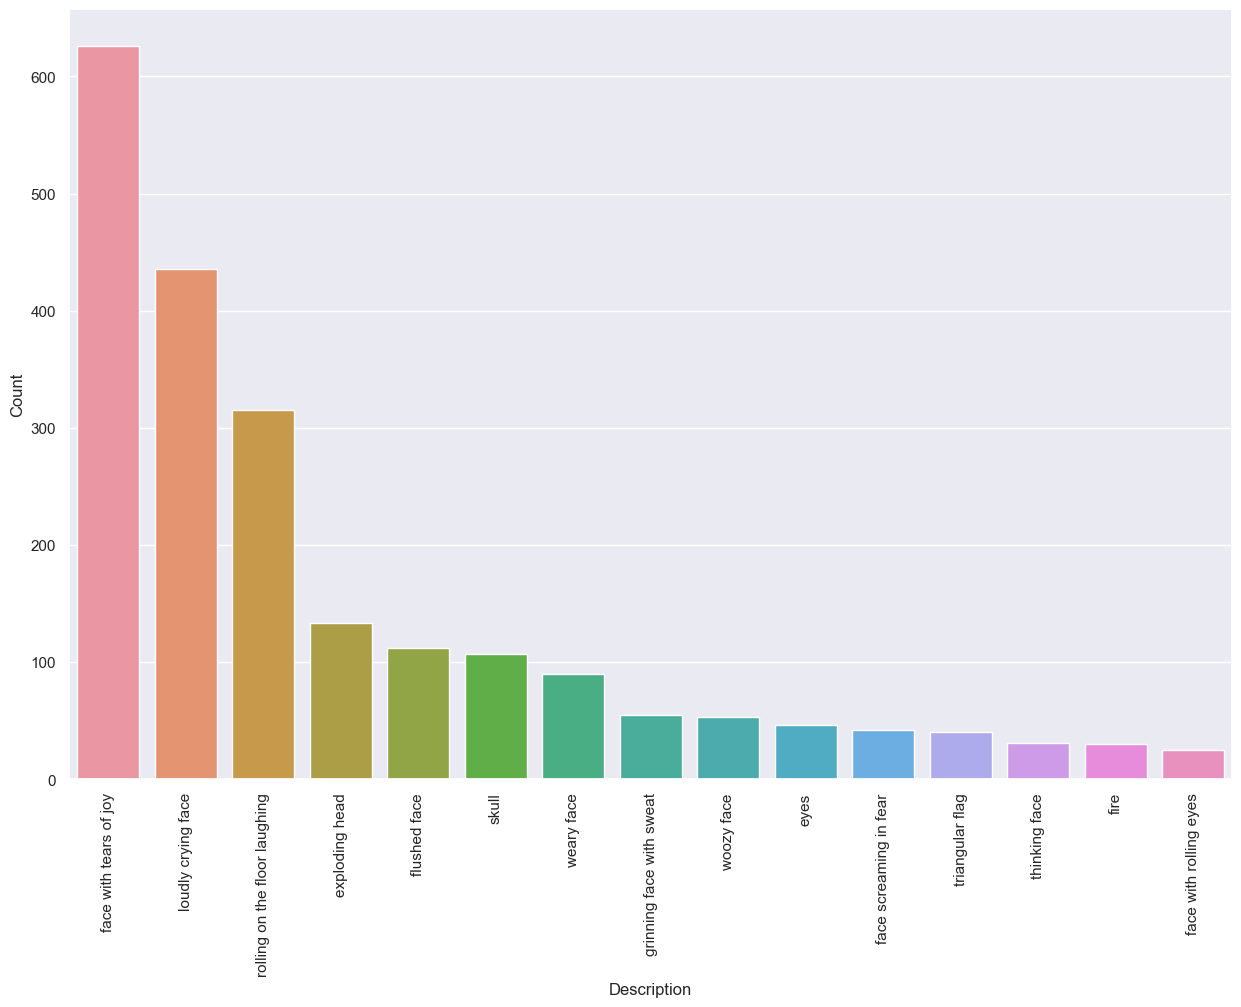

In [44]:
from pathlib import Path
import matplotlib as mpl

# fpath = Path(mpl.get_data_path(), "/System/Library/Fonts/Apple Color Emoji.ttc")

plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
# sns.set_style({'font.family': 'Apple Color Emoji'})
ax = sns.barplot(x="desc",y="count", data=df_emoji)
ax.set_xlabel("Description")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


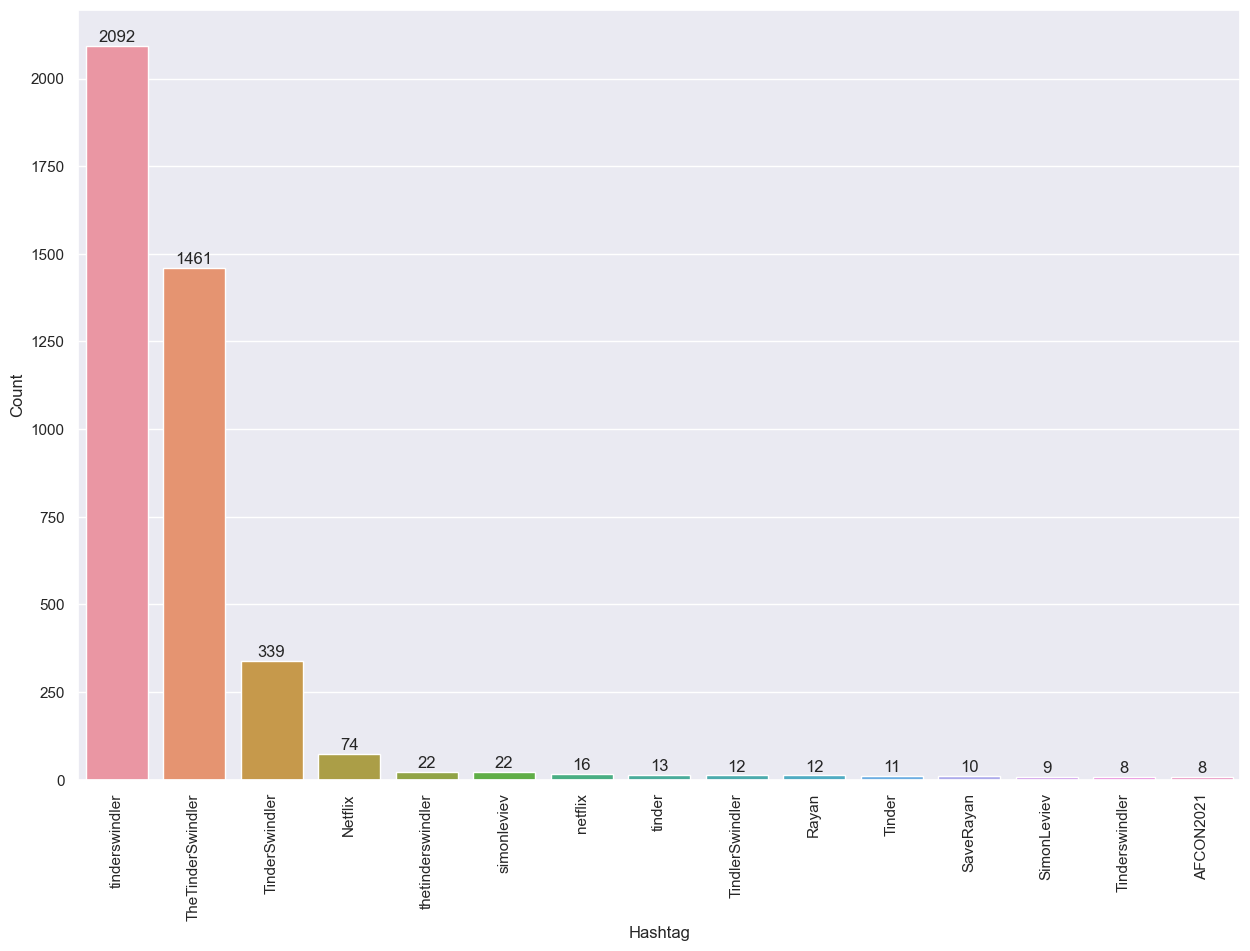

In [45]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="hashtag",y="count", data=df_hashtags)


for p in ax.patches:
    count = f'{p.get_height():.0f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(count, (x, y), ha='center', va='center')

ax.set_xlabel("Hashtag")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


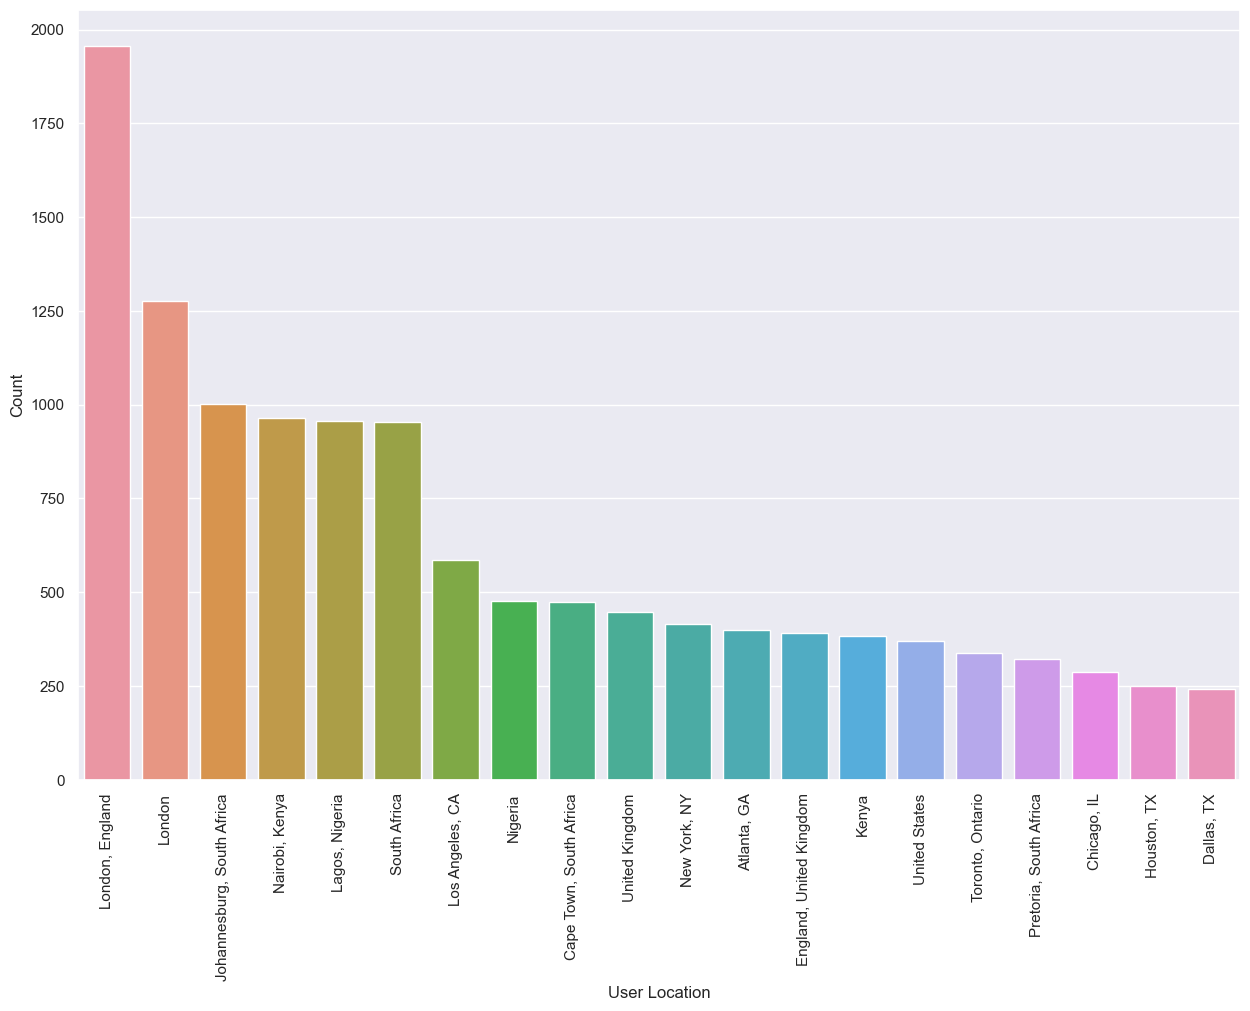

In [46]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="user_location", data=df[df["user_location"] != "unknown"], order=df[df["user_location"] != "unknown"]['user_location'].value_counts().index[0:20])
ax.set_xlabel("User Location")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)

In [47]:
df['datetime_date'] = pd.to_datetime(df['date']).dt.date

In [48]:
df_datecount = df.groupby(by="datetime_date")['datetime_date'].count().reset_index(name="count")

In [49]:
df_datecount

,datetime_date,count
0,2022-02-01,80
1,2022-02-02,3130
2,2022-02-03,6725
3,2022-02-04,9080
4,2022-02-05,13420
5,2022-02-06,14831
6,2022-02-07,11798
7,2022-02-08,11042
8,2022-02-09,6107


Text(0.5, 0, 'Date')

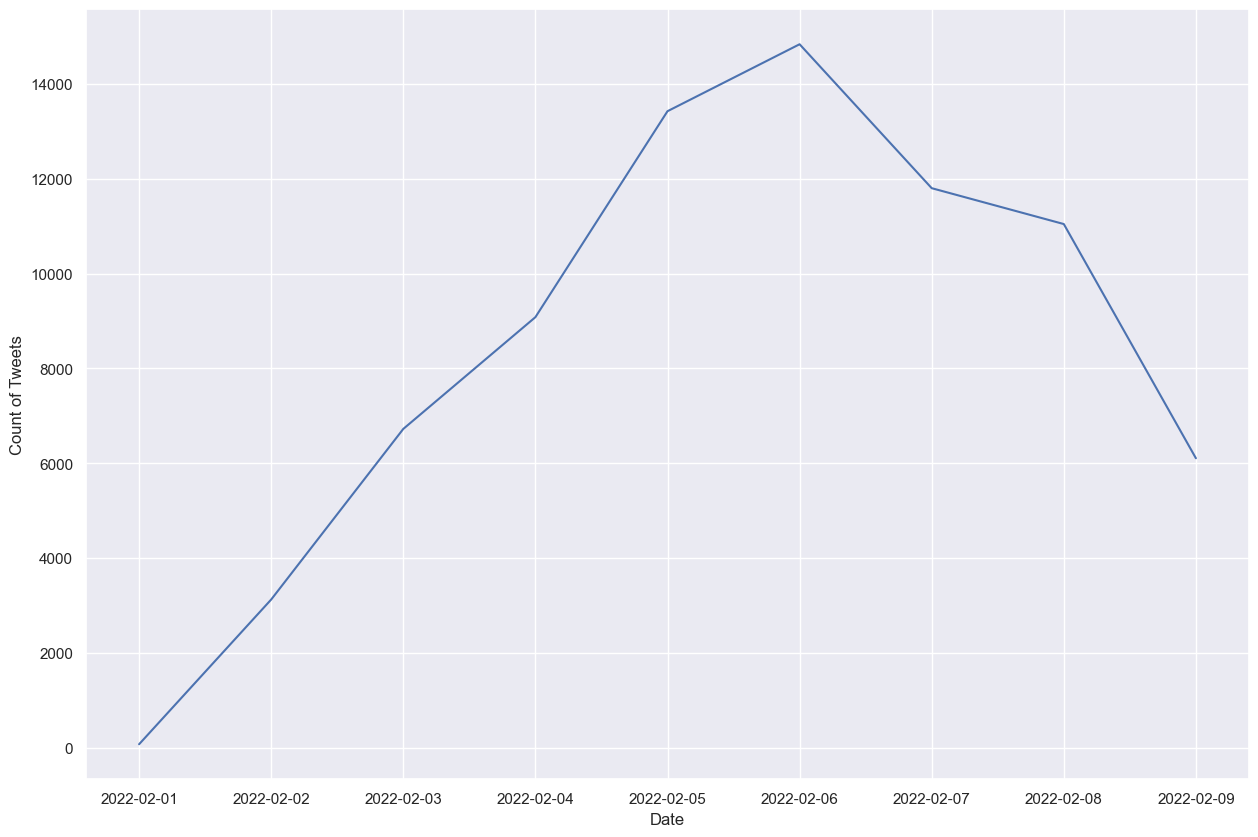

In [50]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.lineplot(data=df_datecount,x=df_datecount["datetime_date"], y=df_datecount['count'].value_counts().index)
ax.set_ylabel("Count of Tweets")
ax.set_xlabel("Date")

The film was released on Netflix on February 2, 2022

In [53]:
# word count
words = [item for sublist in pre_proccesed_tokens for item in sublist]
cv = CountVectorizer().fit(words)
texts_count = cv.transform(words)
sum_words = texts_count.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)


In [54]:
top_20_words = words_freq[:20]

In [55]:
df_word_freq = pd.DataFrame.from_records(top_20_words, columns = ['word', 'count'])

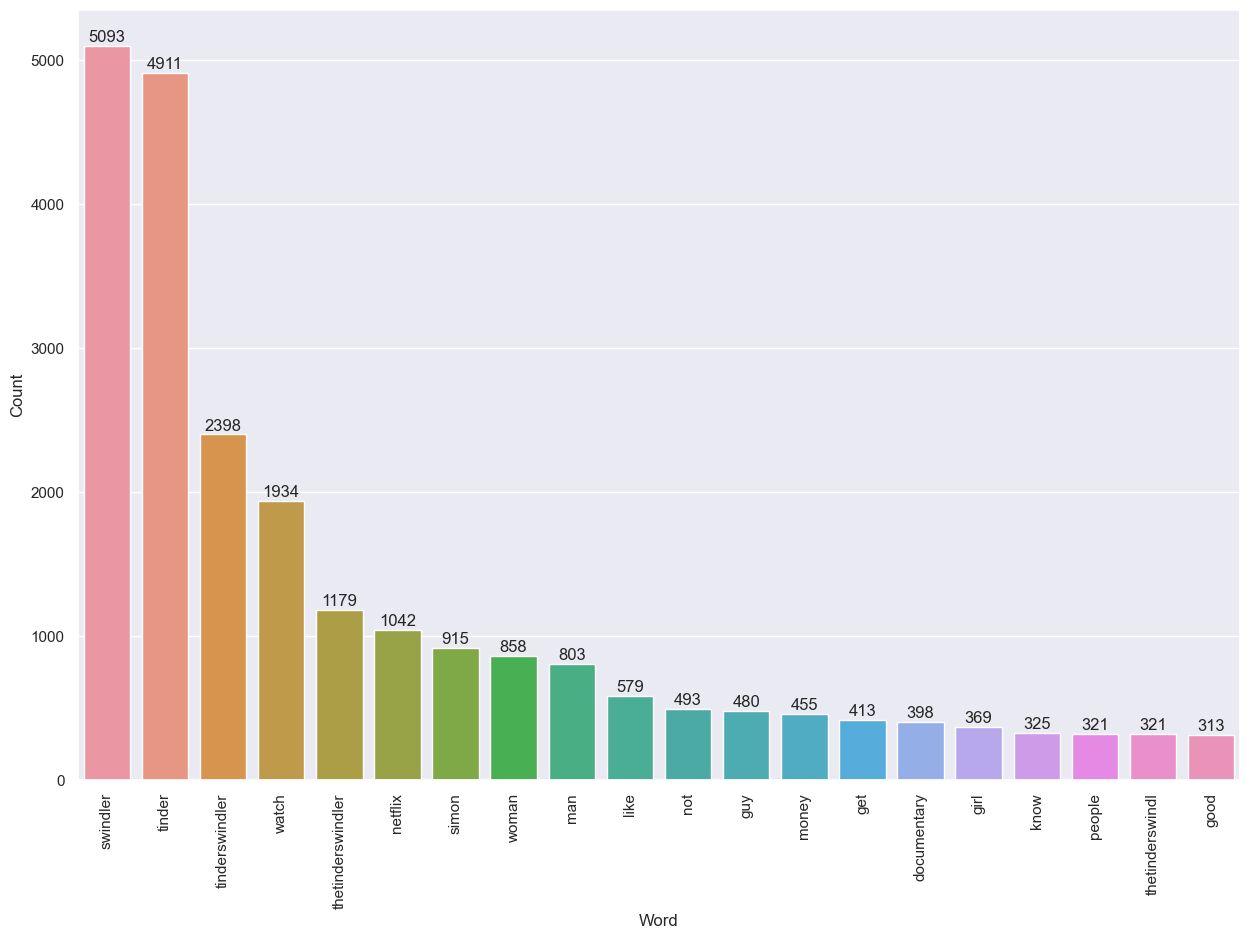

In [56]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="word",y="count", data=df_word_freq)

for p in ax.patches:
    count = f'{p.get_height():.0f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(count, (x, y), ha='center', va='center')

ax.set_xlabel("Word")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


### Sentiment Analysis

In [57]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [58]:
df_sample.text

76111    Hello to all my friends, I live in Afghanistan...
5126     Hope they finally got all the money back with ...
9669     Started listening to this after all the buzz a...
63377    I don’t care what anyone says, if he’s rich or...
67564    Bathong he lives as a free man 😩😩😩😩 #tinderswi...
                               ...                        
16622    Hold up y'all.. I've just watched #TinderSwind...
58325    Just watched Tinder Swindler. Whilst I wasn’t ...
8937     On the subject of the #tinderswindler I felt s...
59071                     The tinder swindler is a madness
18918    Bathong Simon 💀💀💀😂only just finished the tinde...
Name: text, Length: 10000, dtype: object

In [62]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alexanderkneis/nltk_data...


True

In [113]:
df_preprocessed_text = pd.DataFrame(pre_proccesed_texts, columns=['text'])

In [115]:
df_preprocessed_text[['polarity', 'subjectivity']] = df_preprocessed_text['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [130]:
for index, row in df_preprocessed_text['text'].items():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df_preprocessed_text.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        df_preprocessed_text.loc[index, 'sentiment'] = "positive"
    else:
        df_preprocessed_text.loc[index, 'sentiment'] = "neutral"
    df_preprocessed_text.loc[index, 'neg'] = neg
    df_preprocessed_text.loc[index, 'neu'] = neu
    df_preprocessed_text.loc[index, 'pos'] = pos
    df_preprocessed_text.loc[index, 'compound'] = comp

In [131]:
df_preprocessed_text.head()

,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,hello friend live Afghanistan Taliban ask fina...,0.068182,0.250000,positive,0.000,0.543,0.457,0.7096
1,hope finally get money exposure Netflix specia...,0.178571,0.785714,positive,0.000,0.517,0.483,0.6808
2,start listen buzz #tinderswindler. \n\n INSANE...,-1.000000,1.000000,negative,0.292,0.425,0.283,-0.0258
3,"care say rich wealthily ask 25,000 se …",0.437500,0.875000,positive,0.000,0.290,0.710,0.8689
4,Bathong live free man 😩 😩 😩 😩 #tinderswindler,0.268182,0.650000,positive,0.000,0.548,0.452,0.5106


In [138]:
df_preprocessed_text_negative = df_preprocessed_text[df_preprocessed_text["sentiment"]=="negative"]
df_preprocessed_text_positive = df_preprocessed_text[df_preprocessed_text["sentiment"]=="positive"]
df_preprocessed_text_neutral = df_preprocessed_text[df_preprocessed_text["sentiment"]=="neutral"]

In [146]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
df_sentiment = count_values_in_column(df_preprocessed_text,"sentiment")

print(df_sentiment)

          Total  Percentage
neutral    3737       37.37
negative   3222       32.22
positive   3041       30.41


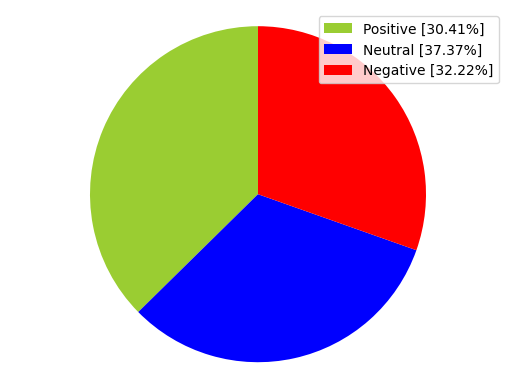

In [147]:
labels = ['Positive ['+str(df_sentiment['Percentage']['positive'])+'%]' , 'Neutral ['+str(df_sentiment['Percentage']['neutral'])+'%]','Negative ['+str(df_sentiment['Percentage']['negative'])+'%]']
sizes = df_sentiment['Percentage']
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.axis('equal')
plt.show()

### LDA